In [16]:
from collections import defaultdict

import matplotlib.pyplot as plt
from numpy import array, cumsum, max, mean, min, ndarray, std, triu_indices
from pandas import DataFrame, Series, merge, read_pickle
from scipy.stats import kurtosis, skew
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

data = read_pickle("../data/raw/mini_gm_public_v0.1.p")

## **DATA PROCESSING**:

In [17]:
df = DataFrame.from_dict(
    [
        {
            "syndrome_id": syndrome_id,
            "subject_id": subject_id,
            "image_id": image_id,
            "embedding": embedding,
        }
        for syndrome_id, subjects in data.items()
        for subject_id, images in subjects.items()
        for image_id, embedding in images.items()
    ]
)
df["embedding_id"] = df["subject_id"] + "_" + df["image_id"]
embeddings = df[["embedding_id", "embedding"]]

In [18]:
df_exploded = embeddings.explode("embedding")
df_exploded["embedding_index"] = df_exploded.groupby("embedding_id").cumcount()
df_pivoted = (
    df_exploded.pivot(
        index="embedding_id", columns="embedding_index", values="embedding"
    )
    .set_axis([f"embedding_{i}" for i in range(320)], axis=1)
    .reset_index()
)

In [19]:
(df := df.drop(columns=["embedding"])).to_csv(
    "../data/interim/flattened_data.csv", index=False
)
df_pivoted.to_csv("../data/interim/embeddings.csv", index=False)
merge(df, df_pivoted, on="embedding_id", how="left").to_csv(
    "../data/interim/complete_data.csv", index=False
)

## **DATA ANALYSIS**:

In [20]:
print(
    df.isna().sum(),
    f"\n{'-' * 12}",
    "\nDuplicates found:",
    df[["syndrome_id", "subject_id", "image_id"]].duplicated().sum(),
)

syndrome_id     0
subject_id      0
image_id        0
embedding_id    0
dtype: int64 
------------ 
Duplicates found: 0


## Sujects & Syndromes:

- Não vale a pena levar em consideração a qunatidade de imagens pro sujeito, a maioria só possui 1 imagem.
- Classes desbalanceadas, com a maior sendo '300000034' e a menor '700018215'

Number of syndromes: 10
Number of images: 1116


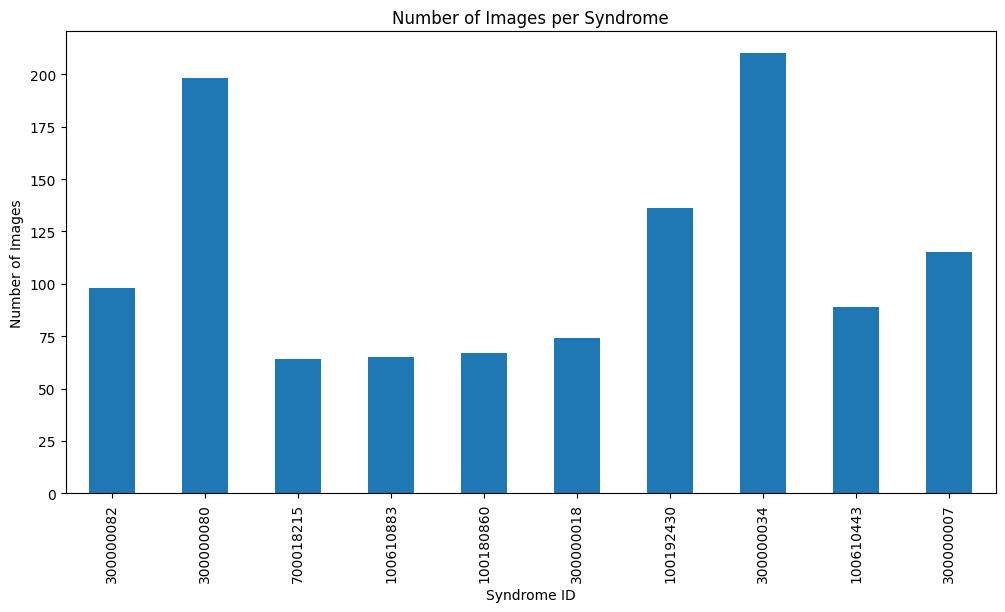

Syndromes with fewer images than 111.6: 
300000082    98
700018215    64
100610883    65
100180860    67
300000018    74
100610443    89
dtype: int64


In [21]:
def analyze_dataset(
    df: DataFrame,
) -> tuple[dict[str, int], dict[str, defaultdict]]:
    """
    Calculate dataset df_stats and visualize the distribution of images per syndrome.

    Args:
        df (pd.DataFrame): DataFrame containing the data with columns 'syndrome_id', 'subject_id', and 'image_id'

    Returns:
        tuple[dict[str, int], dict[str, defaultdict]]: tuple containing 2 Dictionary with dataset statistics
    """
    # Extract columns
    syndrome_ids = df["syndrome_id"].tolist()
    subject_ids = df["subject_id"].tolist()
    image_ids = df["image_id"].tolist()
    total_images = len(image_ids)

    df_stats = {
        "total_images": len(image_ids),
        "total_subjects": len(set(subject_ids)),
        "total_syndromes": len(set(syndrome_ids)),
        # "subject_distribution": {},
    }
    syndrome_stats = {
        "images_per_syndrome": defaultdict(int),
        "subjects_per_syndrome": defaultdict(set),
        "class_balance": defaultdict(float),
        # "images_per_subject": defaultdict(int),
    }
    for syndrome_id in syndrome_ids:
        syndrome_stats["images_per_syndrome"][syndrome_id] += 1

    syndrome_stats["class_balance"] = {
        k: v / total_images for k, v in syndrome_stats["images_per_syndrome"].items()
    }
    for syndrome_id, subject_id in zip(syndrome_ids, subject_ids):
        syndrome_stats["subjects_per_syndrome"][syndrome_id].add(subject_id)

    syndrome_stats["subjects_per_syndrome"] = {
        k: len(v) for k, v in syndrome_stats["subjects_per_syndrome"].items()
    }
    # for subject_id in subject_ids:
    #     syndrome_stats["images_per_subject"][subject_id] += 1

    # df_stats["subject_distribution"] = {
    #     "mean_images": mean(list(df_stats["images_per_subject"].values())),
    #     "median_images": median(list(df_stats["images_per_subject"].values())),
    #     "std_images": std(list(df_stats["images_per_subject"].values())),
    #     "min_images": min(df_stats["images_per_subject"].values()),
    #     "max_images": max(df_stats["images_per_subject"].values()),
    # }
    print(f"Number of syndromes: {df_stats['total_syndromes']}")
    print(f"Number of images: {df_stats['total_images']}")

    images_per_syndrome_series = Series(syndrome_stats["images_per_syndrome"])

    plt.figure(figsize=(12, 6))
    images_per_syndrome_series.plot(kind="bar")
    plt.title("Number of Images per Syndrome")
    plt.xlabel("Syndrome ID")
    plt.ylabel("Number of Images")
    plt.show()

    # Calculate imbalance threshold and print syndromes below it
    imbalance_threshold = df_stats["total_images"] / df_stats["total_syndromes"]
    print(
        f"Syndromes with fewer images than {imbalance_threshold}: \n"
        f"{images_per_syndrome_series[images_per_syndrome_series < imbalance_threshold]}"
    )
    return df_stats, syndrome_stats


statistics, syndrome_stats = analyze_dataset(df)

In [22]:
# json.dumps(statistics)
statistics

{'total_images': 1116, 'total_subjects': 941, 'total_syndromes': 10}

In [23]:
images = syndrome_stats["images_per_syndrome"]
subjects = syndrome_stats["subjects_per_syndrome"]
balances = syndrome_stats["class_balance"]

syndromes = DataFrame(
    [
        {
            "syndrome_id": syndrome_id,
            "images": images[syndrome_id],
            "subjects": subjects[syndrome_id],
            "class_balance": balances[syndrome_id],
        }
        for syndrome_id in images
    ]
).set_index("syndrome_id")

C:\Users\VDUART10\AppData\Local\Temp\ipykernel_60836\3552299016.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


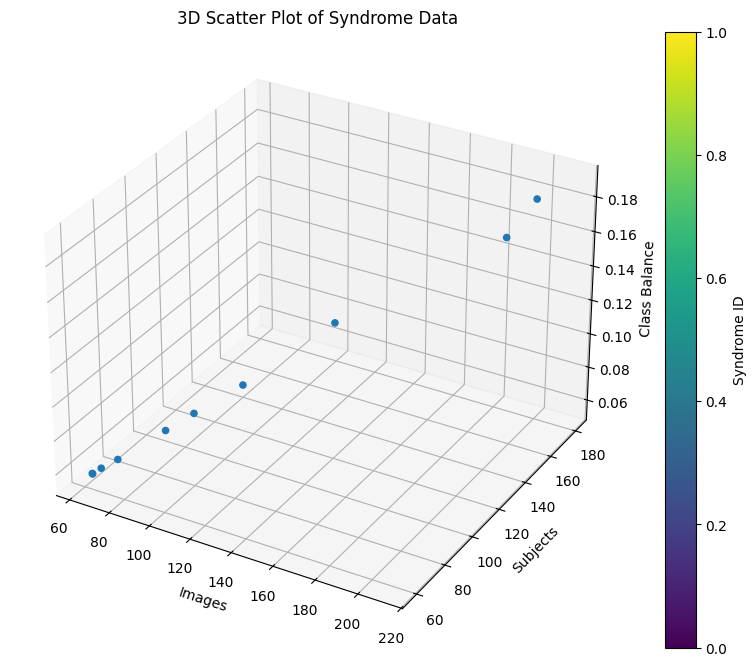

In [31]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    syndromes["images"],
    syndromes["subjects"],
    syndromes["class_balance"],
    c="#1f77b4",
    alpha=1,
    cmap="viridis",
)
ax.set_xlabel("Images")
ax.set_ylabel("Subjects")
ax.set_zlabel("Class Balance")
ax.set_title("3D Scatter Plot of Syndrome Data")

fig.colorbar(scatter, label="Syndrome ID")
plt.show()

## Analise dos dados: Embeddings

In [ ]:
def analyze_embeddings(embeddings: ndarray, syndrome_ids: list) -> dict:
    """
    Analyze the embeddings data with advanced statistics
    Args:
        embeddings (ndarray): Matrix of embeddings
        syndrome_ids (List): List of syndrome IDs

    Returns:
        Dict: Dictionary containing embedding statistics
    """
    # Basic statistics
    embedding_stats = {
        "embedding_dim": embeddings.shape[1],
        "mean": mean(embeddings, axis=0),
        "std": std(embeddings, axis=0),
        "min": min(embeddings, axis=0),
        "max": max(embeddings, axis=0),
        "skewness": skew(embeddings, axis=0),
        "kurtosis": kurtosis(embeddings, axis=0),
    }
    pca = PCA().fit_transform(embeddings)
    embedding_stats["explained_variance_ratio"] = pca.explained_variance_ratio_
    embedding_stats["cumulative_variance_ratio"] = cumsum(pca.explained_variance_ratio_)

    # Calculate within-class and between-class statistics
    unique_syndromes = list(set(syndrome_ids))
    within_class_distances = []
    between_class_distances = []

    for syndrome in unique_syndromes:
        # Get embeddings for current syndrome
        syndrome_mask = array(syndrome_ids) == syndrome
        syndrome_embeddings = embeddings[syndrome_mask]

        # Calculate within-class distances
        if len(syndrome_embeddings) > 1:
            distances = cosine_similarity(syndrome_embeddings)
            # Get upper triangle of distance matrix (excluding diagonal)
            distances = distances[triu_indices(len(distances), k=1)]
            within_class_distances.extend(distances)

        # Calculate between-class distances
        other_embeddings = embeddings[~syndrome_mask]
        if len(syndrome_embeddings) > 0 and len(other_embeddings) > 0:
            distances = cosine_similarity(syndrome_embeddings, other_embeddings)
            between_class_distances.extend(distances.flatten())

    embedding_stats["within_class_similarity"] = {
        "mean": mean(within_class_distances),
        "std": std(within_class_distances),
        "min": min(within_class_distances),
        "max": max(within_class_distances),
    }
    embedding_stats["between_class_similarity"] = {
        "mean": mean(between_class_distances),
        "std": std(between_class_distances),
        "min": min(between_class_distances),
        "max": max(between_class_distances),
    }
    return embedding_stats